In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.version


'3.8.13 (default, Mar 28 2022, 06:13:39) \n[Clang 12.0.0 ]'

In [20]:
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt
import matplotlib.animation as anim
import seaborn as sns

from tqdm import tqdm
from scipy.linalg import solve_continuous_are
import hj_reachability as hj
from cbf_opt import asif, cbf, dynamics
import refine_cbfs
from experiment_wrapper import StateSpaceExperiment

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


In [4]:
import matplotlib

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.size": "32",
        "text.usetex": False,
        "pgf.rcfonts": False,
        "lines.linewidth": 6.0,
    }
)

params = {
    "axes.labelsize": 28,
    "axes.titlesize": 28,
    "font.size": 28,
    "legend.fontsize": 28,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "lines.linewidth": 5,
}
matplotlib.rcParams.update(params)


In [5]:
class InvPendulumDynamics(dynamics.ControlAffineDynamics):
    STATES = ["THETA", "THETA_DOT"]
    CONTROLS = ["U"]

    def __init__(self, params, **kwargs):
        params["n_dims"] = 2
        params["control_dims"] = 1  # TODO: How to do this correctly?
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        f = np.zeros_like(state)
        f[..., 0] = state[..., 1]
        f[..., 1] = np.sin(state[..., 0])
        return f

    def control_matrix(self, state, time=0.0):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 1, 0] = 1
        return B

    def state_jacobian(self, state, control, time=0.0):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 1] = 1
        J[..., 1, 0] = np.cos(state[..., 0])
        return J


class InvPendulumJNPDynamics(InvPendulumDynamics):
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([state[1], jnp.sin(state[0])])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 1]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(2), axis=-1)


In [6]:
inv_pend = InvPendulumDynamics({"dt": 0.01})
inv_pend_jnp = InvPendulumJNPDynamics({"dt": 0.01})

## Backup controller
We consider the backup controller to be an LQR controller computed at $x_{\text{nom}} = [0, 0], u_\text{nom} = 0$

In [7]:
class InvPendulumBackupController(cbf.BackupController):
    def __init__(self, dynamics, T_backup, **kwargs):
        self.lqr_term = kwargs.get("lqr_term", np.zeros((dynamics.control_dims, dynamics.n_dims)))
        super().__init__(dynamics, T_backup, **kwargs)

    def policy(self, x, t):
        return np.minimum(np.maximum(-(self.lqr_term @ x.T).T, self.umin), self.umax)

    def grad_policy(self, x, t):
        return -self.lqr_term


In [8]:
xnom = np.zeros(inv_pend.n_dims)
unom = np.zeros(inv_pend.control_dims)

umax = 3 * np.ones(inv_pend.control_dims)
umin = -umax

A = inv_pend.state_jacobian(xnom, unom)
B = inv_pend.control_jacobian(xnom, unom)
Q = np.eye(inv_pend.n_dims)
R = 1e4 * np.eye(inv_pend.control_dims)

P = solve_continuous_are(A, B, Q, R)
F = np.linalg.inv(R) @ B.T @ P

backup_controller = InvPendulumBackupController(inv_pend, T_backup=3.5, lqr_term=F, umin=umin, umax=umax)


## Implicit CBF

The safety value function is a candidate CBF, just not a valid one. Still uses same code structure

In [9]:
class InvPendulumSafetyCBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        return np.minimum(1 - state[..., 0] ** 2, 2 - state[..., 1] ** 2)

    def vf_dt_partial(self, state, time):
        return 0.0

    def _grad_vf(self, state, time=0.0):
        dvf_dx = np.zeros_like(state)
        mask = 1 - state[..., 0] ** 2 < 2 - state[..., 1] ** 2
        dvf_dx[..., 0] = -2 * state[..., 0] * mask
        dvf_dx[..., 1] = -2 * state[..., 1] * ~mask
        return dvf_dx


class InvPendulumImplicitCBF(cbf.ControlAffineImplicitCBF):
    def __init__(self, dynamics, params, backup_controller, safety_cbf, **kwargs):
        self.delta = params["delta"]
        self.backup_vf_scalar = kwargs.get("backup_vf_scalar", 100)
        super().__init__(dynamics, params, backup_controller, safety_cbf, **kwargs)

    def backup_vf(self, state, time=0.0):
        return self.backup_vf_scalar * np.minimum(
            (np.pi / 12) ** 2 - state[..., 0] ** 2, self.delta**2 - state[..., 1] ** 2
        )

    def _grad_backup_vf(self, state, time=0.0):
        dvf_dx = np.zeros_like(state)
        mask = (np.pi / 12) ** 2 - state[..., 0] ** 2 < self.delta**2 - state[..., 1] ** 2
        dvf_dx[..., 0] = -2 * state[..., 0] * mask
        dvf_dx[..., 1] = -2 * state[..., 1] * ~mask
        return self.backup_vf_scalar * dvf_dx


In [10]:
safety_cbf = InvPendulumSafetyCBF(inv_pend_jnp, {})
inv_pend_cbf = InvPendulumImplicitCBF(
    inv_pend, params={"delta": 0.1}, backup_controller=backup_controller, safety_cbf=safety_cbf
)


In [11]:
dyn_reachability = refine_cbfs.HJControlAffineDynamics(inv_pend_jnp, control_space=hj.sets.Box(umin, umax))


In [12]:
low_bound = np.array([-np.pi, -np.pi])
high_bound = np.array([np.pi, np.pi])
nbr_pts = (101, 101)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)


In [13]:
inv_pend_tabular_cbf = refine_cbfs.TabularControlAffineCBF(inv_pend, dict(), grid=grid)
grid_states_np = np.array(grid.states)
inv_pend_tabular_cbf.vf_table = np.zeros((grid.states.shape[0], grid.states.shape[1]))
for x_grid in tqdm(range(grid.states.shape[0])):
    for y_grid in range(grid.states.shape[1]):
        inv_pend_tabular_cbf.vf_table[x_grid, y_grid] = inv_pend_cbf.vf(
            grid_states_np[x_grid, y_grid], break_unsafe=False
        )


100%|██████████| 101/101 [00:55<00:00,  1.81it/s]


In [14]:
init_value = inv_pend_tabular_cbf.vf_table
obstacle = jnp.minimum(1 - grid.states[..., 0] ** 2, 2 - grid.states[..., 1] ** 2)
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("very_high", value_postprocessor=backwards_reachable_tube(obstacle))


In [15]:
time = 0.0
target_time = -2.0
times = np.linspace(time, target_time, 101)
target_values = hj.solve(solver_settings, dyn_reachability, grid, times, init_value)


100%|##########|  2.0000/2.0 [00:00<00:00,  7.95sim_s/s]


In [16]:
time = 0.0
target_time = -20.0
viability_kernel_vf = hj.step(solver_settings, dyn_reachability, grid, time, obstacle, target_time)


100%|##########| 20.0000/20.0 [00:01<00:00, 10.71sim_s/s]


In [17]:
nominal_policy = lambda x, t: np.atleast_1d(2.0)

alpha = lambda x: 5 * x

trade_off_filter = asif.TradeoffFilter(
    inv_pend, inv_pend_cbf, backup_controller, nominal_policy=nominal_policy, beta=30.0
)
ca_tabular_cbf = refine_cbfs.TabularControlAffineCBF(inv_pend, grid=grid)
ca_tabular_cbf.vf_table = target_values[-1]

cbvf = asif.ControlAffineASIF(
    inv_pend, ca_tabular_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax
)


## Simulation 

In [18]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.1, 0.1, 0.1))
chosen_colors.append((0.7, 0.7, 0.7))


In [21]:
x0 = np.array([0.0, 0.0])

experiment = StateSpaceExperiment(inv_pend, start_x=x0, x_indices=[0, 1], n_sims_per_start=1, t_sim=5)


In [22]:
results_df = experiment.run(inv_pend, {"nominal": nominal_policy, "tradeoff": trade_off_filter, "other": cbvf})


Controller rollout: 100%|██████████| 500/500 [00:04<00:00, 118.70it/s]


## Plotting figure for the paper

In [23]:
save_figure = False
file_name = "inv_pendulum.png"

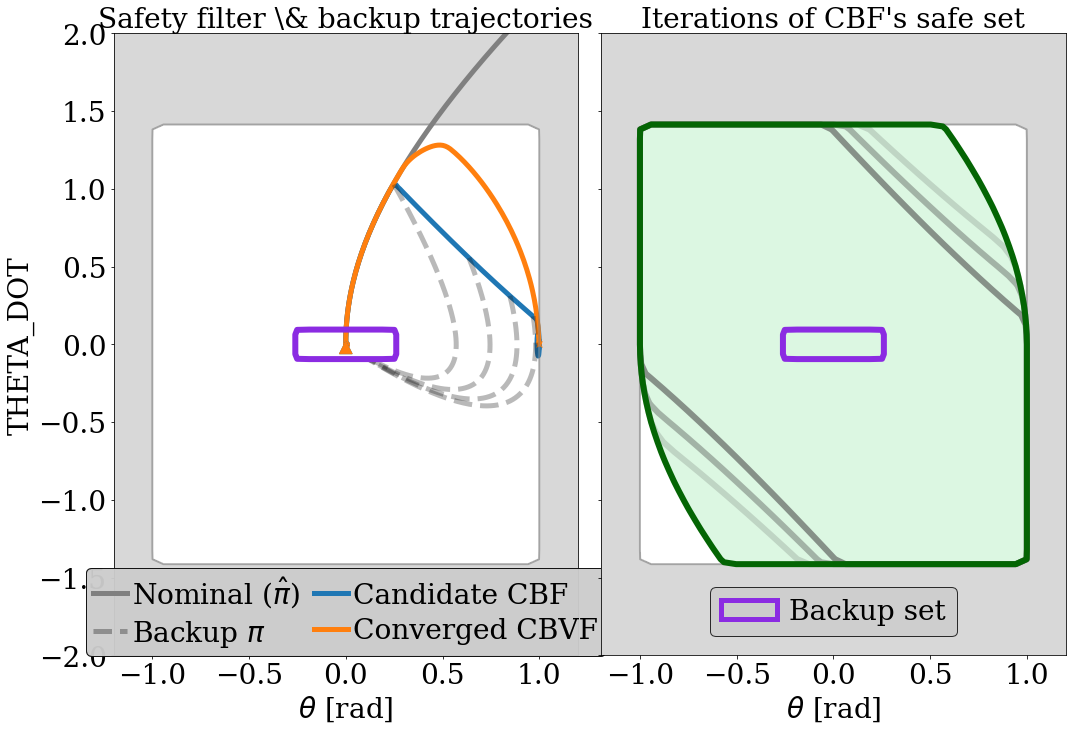

In [24]:
a_col = np.array([sns.color_palette("bright")[4]])
i = 10
fig, axs = plt.subplots(1, 2, figsize=(15, 10.25), sharey=True)
blue_colors = sns.color_palette("PuBuGn", 5).as_hex()
gen_colors = sns.color_palette("Set2", 9).as_hex()
alt_colors = sns.color_palette("pastel", 9).as_hex()
ZZ = inv_pend_cbf.backup_vf(grid.states)

XX = grid.coordinate_vectors[0]
YY = grid.coordinate_vectors[1]

ax = axs[0]
ax.set_ylabel(r"$\dot{\theta}$ [rad/s]")
sns.set_palette("colorblind")

experiment.plot(inv_pend, results_df, color=chosen_colors, ax=axs[0])

for i, t in enumerate(results_df.t.unique()[::50]):
    state = results_df[
        (results_df.controller == "tradeoff") & (results_df.t == t) & (results_df.measurement.isin(inv_pend.STATES))
    ].value.values
    states_backedup, _ = backup_controller.rollout_backup(state)
    if i == 0:
        l = ax.plot(
            states_backedup[:, 0], states_backedup[:, 1], "--", alpha=0.3, color=chosen_colors[3], label="Backup $\pi$"
        )
    elif i < 5:
        l2 = ax.plot(
            states_backedup[:, 0], states_backedup[:, 1], "--", alpha=0.3, color=chosen_colors[3], label="_nolegend_"
        )

colors = [(0.3, 0.3, 0.3)]
colors += [(sns.color_palette("RdYlGn_r", 7)[0])]
colors += [(sns.color_palette("RdYlGn_r", 9)[6])]
colors += [(sns.color_palette("RdYlGn_r", 9)[8])]
colors += [(4 / 255, 101 / 255, 4 / 255)]
lines = [ax.lines[::3][i] for i in [0, 3, 1, 2]]
leg2 = ax.legend(
    lines,
    ["Nominal ($\hat \pi$)", "Backup $\pi$", "Candidate CBF", "Converged CBVF"],
    loc="center",
    bbox_to_anchor=(0.5, 0.07),
    ncol=2,
    handletextpad=0.2,
    handlelength=1.2,
    columnspacing=0.5,
    borderpad=0.25,
    labelspacing=0.3,
    facecolor=[0.8, 0.8, 0.8],
    edgecolor="black",
)
proxy = []

cs = ax.contourf(XX, YY, obstacle.T, levels=[-10, 0], colors="grey", alpha=0.3)
cs = ax.contour(XX, YY, obstacle.T, levels=[0], colors="grey", alpha=0.6, linewidths=2)
cs = ax.contour(XX, YY, ZZ.T, levels=[0], colors=a_col, linewidths=6)

ax.set_xlim([-1.2, 1.2])
ax.set_xlabel(r"$\theta$ [rad]")

ax.add_artist(leg2)
ax.set_title(r"Safety filter \& backup trajectories")
ax = axs[1]

proxy = []

cs = ax.contourf(XX, YY, obstacle.T, levels=[-10, 0], colors="grey", alpha=0.3)
cs = ax.contour(XX, YY, obstacle.T, levels=[0], colors="grey", linewidths=2, alpha=0.6)
cs = ax.contourf(XX, YY, viability_kernel_vf.T, levels=[0, 10], colors=alt_colors[2], alpha=0.3)

cs = ax.contour(XX, YY, init_value.T, levels=[0], colors=colors, linewidths=6, alpha=0.6)

cs = ax.contour(XX, YY, target_values[5].T, levels=[0], colors=colors, linewidths=6, alpha=0.4)

cs = ax.contour(XX, YY, ZZ.T, levels=[0], colors=a_col, linewidths=6)
proxy += [plt.Rectangle((0, 0), 1, 1, ec=a_col, fc=(0.8, 0.8, 0.8), lw=5) for pc in cs.collections]
cs = ax.contour(XX, YY, target_values[10].T, levels=[0], colors=colors, alpha=0.2, linewidths=6)


cs = ax.contour(XX, YY, target_values[-1].T, levels=[0], colors=np.array([colors[-1]]), linewidths=6)

leg = ax.legend(
    proxy,
    ["Backup set"],
    loc="center",
    bbox_to_anchor=(0.5, 0.07),
    columnspacing=0.8,
    handletextpad=0.4,
    facecolor=[0.8, 0.8, 0.8],
    edgecolor="black",
)

ax.set_xlabel(r"$\theta$ [rad]")

ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-2, 2])
ax.set_title("Iterations of CBF's safe set")
fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0)

if save_figure:
    fig.savefig(file_name, dpi=400, bbox_inches='tight')
